In [19]:

import subprocess
import sys
import pandas as pd
import random
import torch
import numpy as np
from datasets import Dataset
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
import os
import xml.etree.ElementTree as ET
from datetime import datetime
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
from wordcloud import WordCloud
from collections import Counter
import nltk
import re
warnings.filterwarnings('ignore')
import zipfile

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [20]:
# Setting the directory in jupyterhub
tgz_path="projects/DLSS/assignment4/ParlaMint-AT.tgz"
extract_to = 'projects/DLSS/assignment4/data/ParlaMint-AT'
os.makedirs(extract_to, exist_ok=True)
with tarfile.open(tgz_path, 'r:gz') as tar:
    tar.extractall(path=extract_to)

In [21]:
# Extracting speech data

def parse_speech_segments(base_folder, start_year=2017):
    """
    Parse speech segments from .txt files. Each line = 1 segment.
    Extracts speech_id, date, text.
    """
    speeches = []

    for year_folder in os.listdir(base_folder):
        if not year_folder.isdigit() or int(year_folder) < start_year:
            continue
        year_path = os.path.join(base_folder, year_folder)
        for file in os.listdir(year_path):
            if not file.endswith('.txt') or 'meta' in file:
                continue
            file_path = os.path.join(year_path, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                    if '\t' not in line:
                        continue
                    segment_id, text = line.strip().split('\t', 1)
                    speeches.append({
                        'segment_id': segment_id,
                        'text': text,
                        'file': file,
                        'year': int(year_folder)
                    })
    return pd.DataFrame(speeches)


In [22]:
# Extracting meta data
def load_metadata_tsv(base_folder):
    """
    Load all English metadata tsv files (meta-en.tsv) from all year folders.
    Fix misaligned columns by not treating any column as index.
    Returns a combined dataframe.
    """
    dfs = []
    for year_folder in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, year_folder)
        if not os.path.isdir(folder_path):
            continue
        for file in os.listdir(folder_path):
            if file.endswith('meta-en.tsv'):
                path = os.path.join(folder_path, file)
                df = pd.read_csv(path, sep='\t', encoding='utf-8', index_col=False)

                # If the first column is unnamed, name it 'ID' (or whatever fits)
                if df.columns[0].startswith('Unnamed'):
                    df.columns = ['ID'] + list(df.columns[1:])

                dfs.append(df)

    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


In [23]:
# Cleaning and merging data into final dataframe
def clean_and_merge(speeches, metadata):
    """
    Clean and merge speeches with metadata.
    Filters out short, procedural, missing party, and duplicates.
    """
    # Merge on segment/speech ID
    merged = pd.merge(speeches, metadata, how='left', left_on='segment_id', right_on='ID')

    # Drop speeches with missing or placeholder party
    merged = merged[merged['Speaker_party'] != "-"]
    merged['Speaker_party'] = merged['Speaker_party'].replace({'GRÜNE': 'Grüne'})

    # Filter out short speeches (less than 50 words)
    merged['word_count'] = merged['text'].str.split().apply(len)
    merged = merged[merged['word_count'] >= 50]

    # Remove interruptions/comments in double square brackets
    merged['text'] = merged['text'].str.replace(r'\[\[.*?\]\]', '', regex=True)


    # Remove strictly procedural speeches by chairpersons
    merged = merged[~(merged['Speaker_role'].str.lower() == 'chairperson')]

    # Drop duplicates and convert Speaker_birth to numeric
    merged = merged.drop_duplicates(subset=['text'])
    merged['Speaker_birth'] = pd.to_numeric(merged['Speaker_birth'], errors='coerce')

    # Simplified mapping (you can adjust these mappings as needed)
    orientation_map = {
        "Centre-left to left": "Left",
        "Centre-left": "Left",
        "Centre-right to right": "Right",
        "Right to far-right": "Right",
        "Centre": "Centre",
    }

    # Apply map to full dataset
    merged["Simple_orientation"] = merged["Party_orientation"].map(orientation_map)

    return merged



In [24]:
base_folder = 'projects/DLSS/assignment4/data/ParlaMint-AT/ParlaMint-AT.txt'  # base path

# Load Data
speeches = parse_speech_segments(base_folder, start_year=2017)
print(f"Loaded {len(speeches)} speech files")
metadata = load_metadata_tsv(base_folder)
print(f"Loaded metadata rows: {len(metadata)}")
final_df = clean_and_merge(speeches, metadata).drop(columns=["Text_ID", "ID", "Session", "Meeting", "Agenda"])
print(f"Final dataset: {len(final_df)} rows")

Loaded 46368 speech files
Loaded metadata rows: 231759
Final dataset: 19053 rows


In [25]:
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('german'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


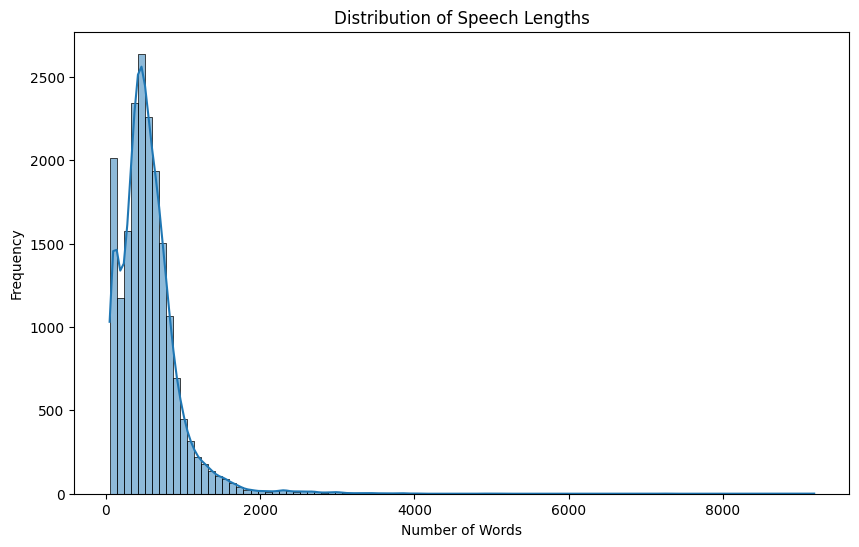

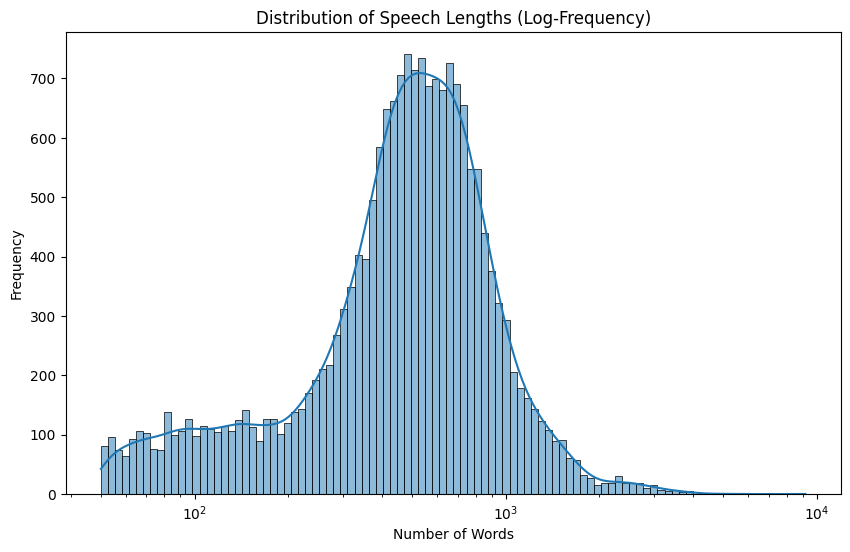

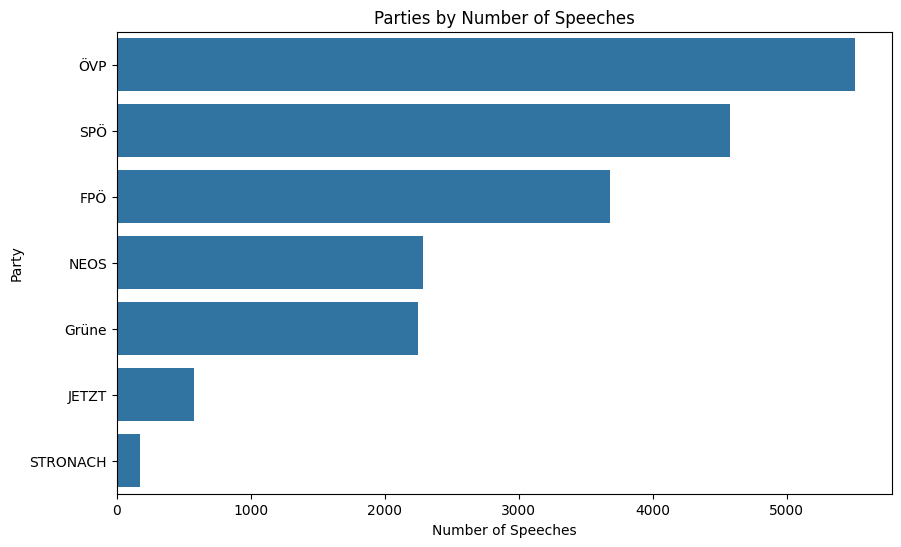

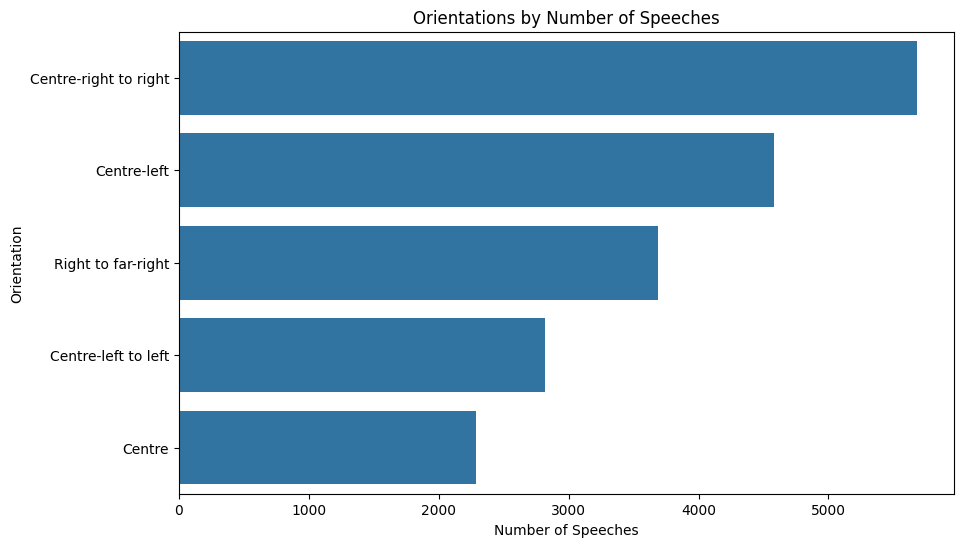

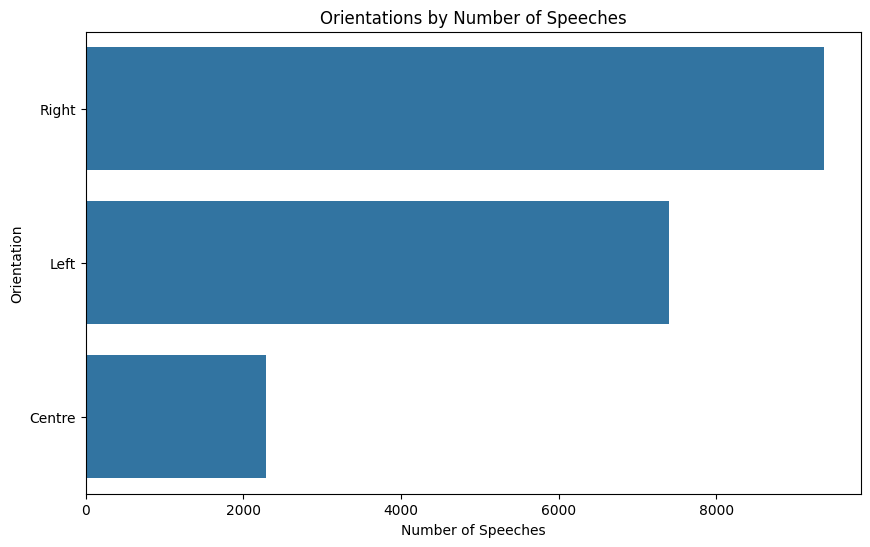

In [26]:
# Distribution of speech lengths (without log-frequency)
plt.figure(figsize=(10, 6))
sns.histplot(final_df['word_count'], bins=100, kde=True, log_scale=False)
plt.title("Distribution of Speech Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Distribution of speech lengths (with log-frequency)
plt.figure(figsize=(10, 6))
sns.histplot(final_df['word_count'], bins=100, kde=True, log_scale=True)
plt.title("Distribution of Speech Lengths (Log-Frequency)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Parties by count
party_counts = final_df['Speaker_party'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=party_counts.values, y=party_counts.index)
plt.title("Parties by Number of Speeches")
plt.xlabel("Number of Speeches")
plt.ylabel("Party")
plt.show()

# Orientations by count
orientation_counts = final_df['Party_orientation'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=orientation_counts.values, y=orientation_counts.index)
plt.title("Orientations by Number of Speeches")
plt.xlabel("Number of Speeches")
plt.ylabel("Orientation")
plt.show()

# Simplified orientations by count
orientation_counts = final_df['Simple_orientation'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=orientation_counts.values, y=orientation_counts.index)
plt.title("Orientations by Number of Speeches")
plt.xlabel("Number of Speeches")
plt.ylabel("Orientation")
plt.show()

In [27]:
# Vocabulary size
all_words = " ".join(final_df['text']).lower()
tokens = re.findall(r'\b\w+\b', all_words)
tokens = [w for w in tokens if w not in stop_words and len(w) > 2]

vocab = set(tokens)
print(f"Vocabulary size: {len(vocab):,}")

# Average speech length
avg_len = final_df['word_count'].mean()
print(f"Average speech length: {avg_len:.2f} words")

# Total number of speeches
print(f"Total speeches: {len(final_df):,}")

Vocabulary size: 161,910
Average speech length: 555.53 words
Total speeches: 19,053


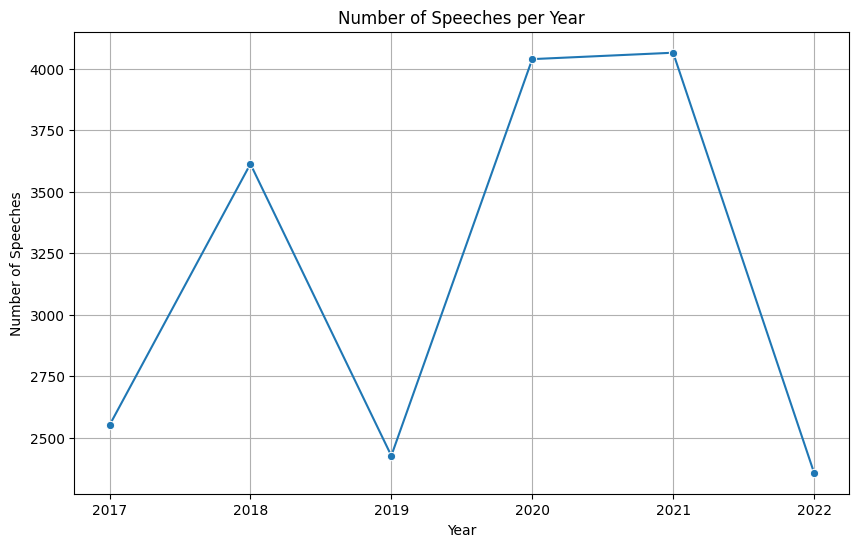

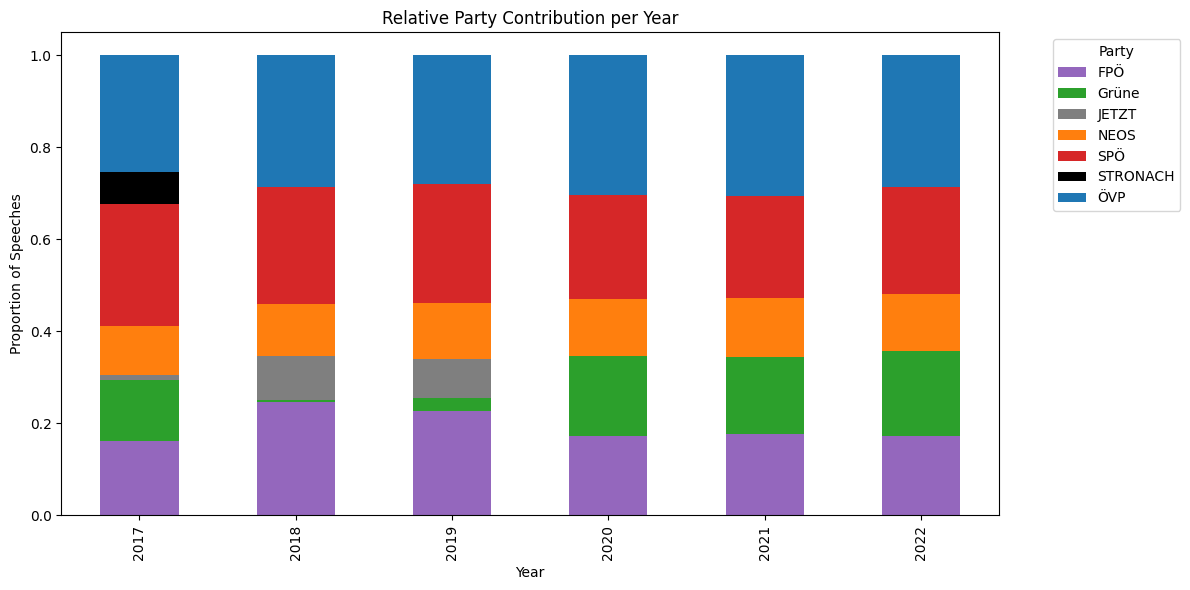

In [28]:
# Yearly Counts
yearly_counts = final_df.groupby('year')['text'].count()
plt.figure(figsize=(10, 6))
sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, marker='o')
plt.title("Number of Speeches per Year")
plt.xlabel("Year")
plt.ylabel("Number of Speeches")
plt.grid(True)
plt.show()

# Party distribution over years (stacked bar)
party_year = final_df.groupby(['year', 'Speaker_party']).size().unstack(fill_value=0)
party_year_pct = party_year.div(party_year.sum(axis=1), axis=0)  # normalize

# Define a custom color mapping for each party
party_colors = {
    'ÖVP': '#1f77b4',     # blue
    'SPÖ': '#d62728',     # red
    'Grüne': '#2ca02c',   # green
    'FPÖ': '#9467bd',     # purple
    'NEOS': '#ff7f0e',    # orange
    'JETZT': '#7f7f7f',   #grey
    'STRONACH':"black"
          
}

# Ensure the color order matches the columns in your DataFrame
column_order = party_year_pct.columns
custom_colors = [party_colors.get(col, '#cccccc') for col in column_order]  # default: light gray if not in dict

# Plot using the custom colors
party_year_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=custom_colors
)

plt.title("Relative Party Contribution per Year")
plt.xlabel("Year")
plt.ylabel("Proportion of Speeches")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Party')
plt.tight_layout()
plt.show()


In [29]:
def plot_wordcloud(party_name=None):
    """
        Word cloud visualizations
    """
    if party_name:
        df = final_df[final_df['Speaker_party'] == party_name]
        title = f"Word Cloud for {party_name}"
    else:
        df = final_df
        title = "Overall Word Cloud of All Speeches"

    # Join text and tokenize
    all_text = " ".join(df['text'].astype(str)).lower()
    tokens = re.findall(r'\b\w+\b', all_text)
    filtered_tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    
    word_freq = Counter(filtered_tokens)
    if not word_freq:
        print(f"No words found for {party_name or 'all speeches'}.")
        return

    # Generate and plot word cloud
    wordcloud = WordCloud(width=1000, height=500, background_color='white',
                          max_words=200, colormap='viridis').generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

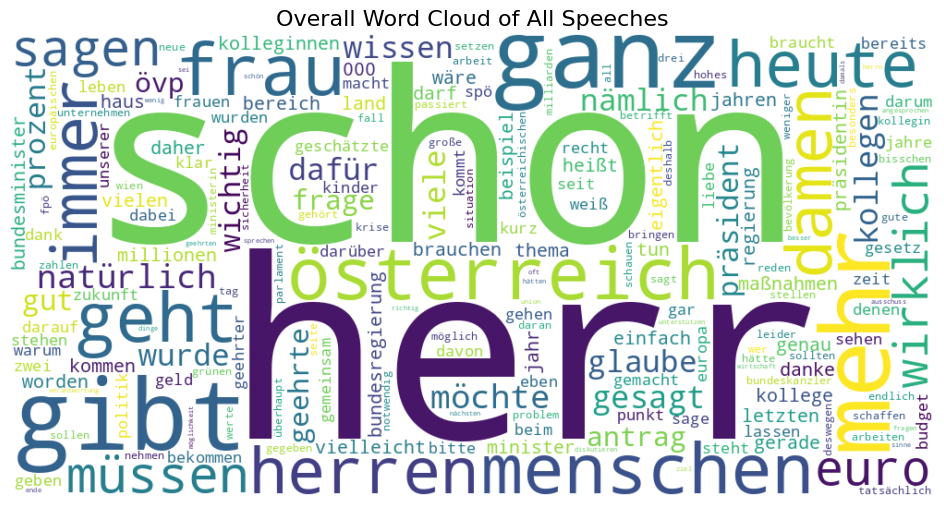

In [30]:
plot_wordcloud()

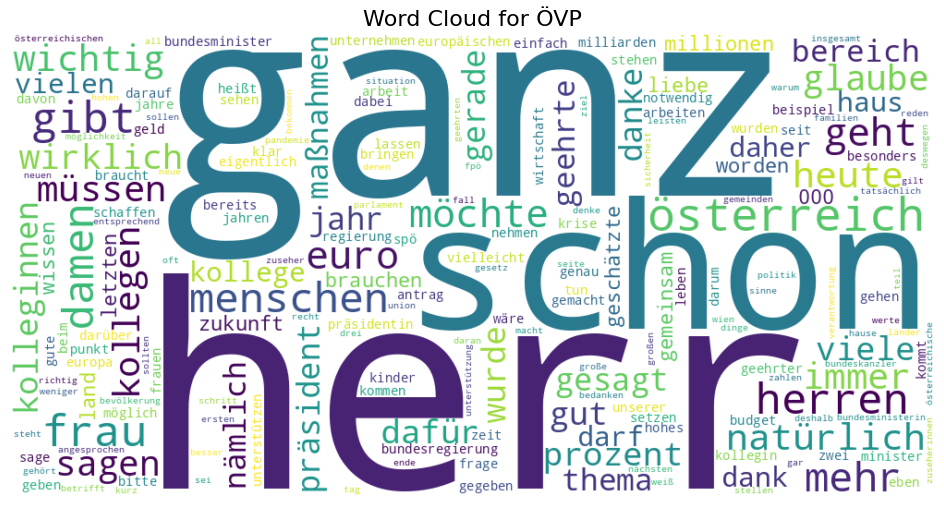

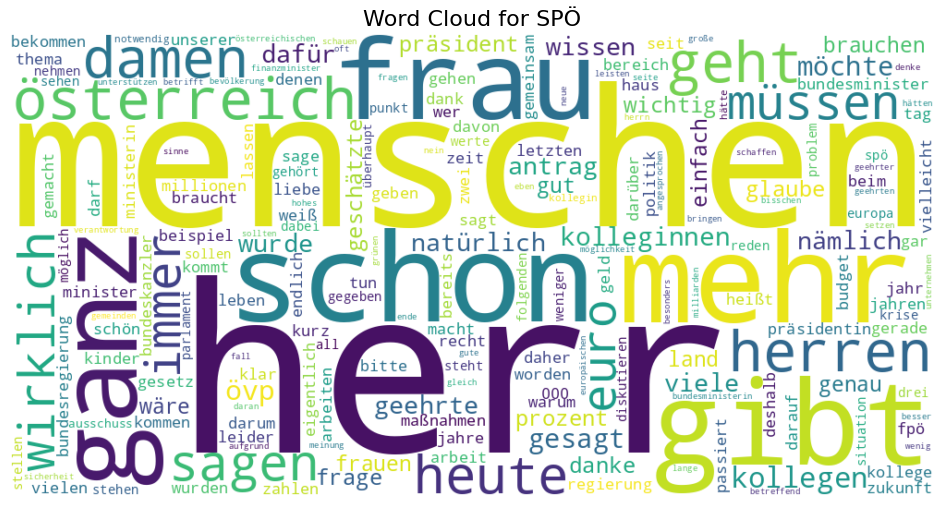

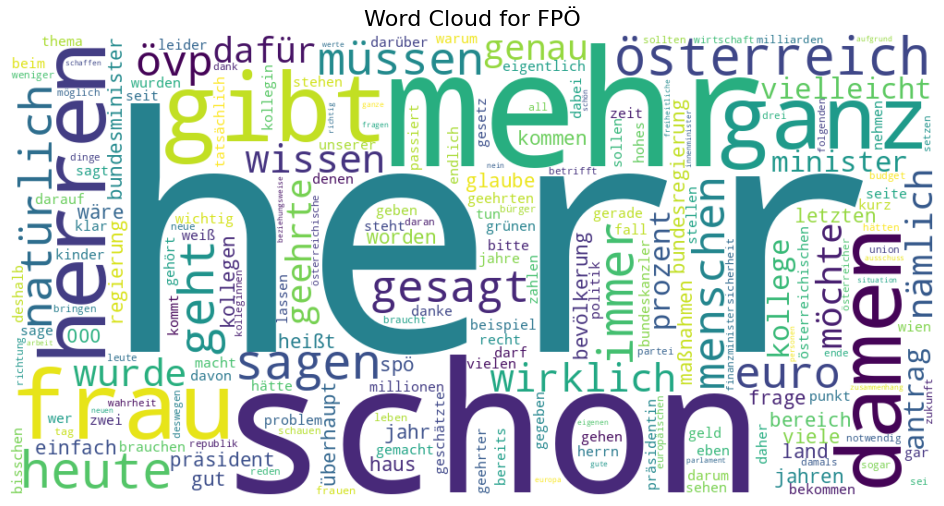

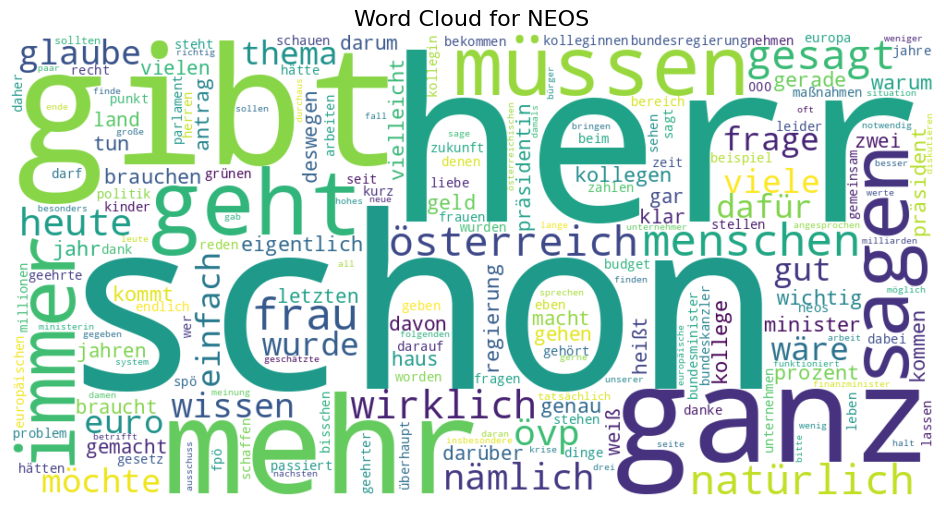

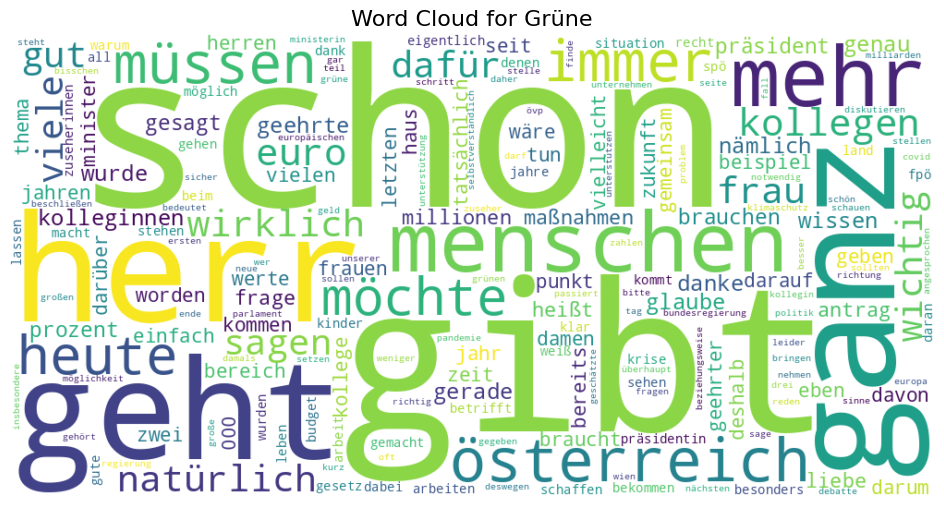

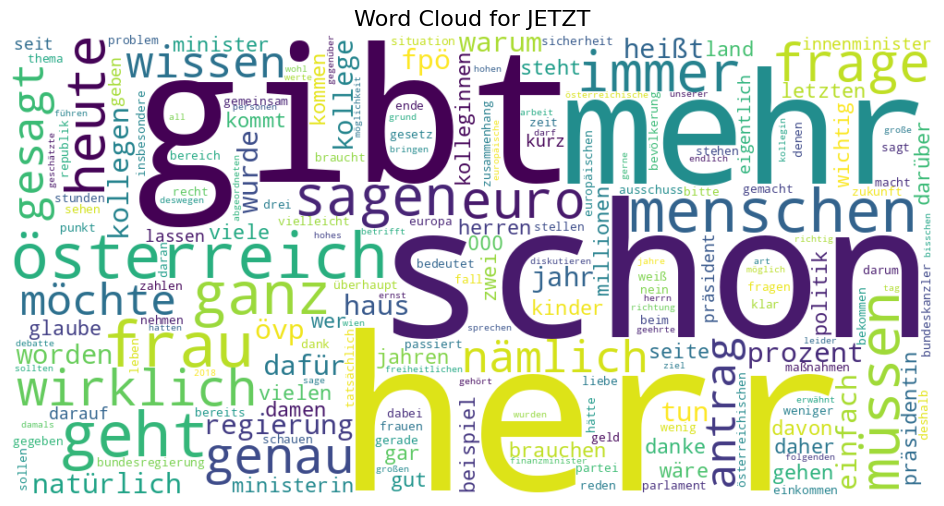

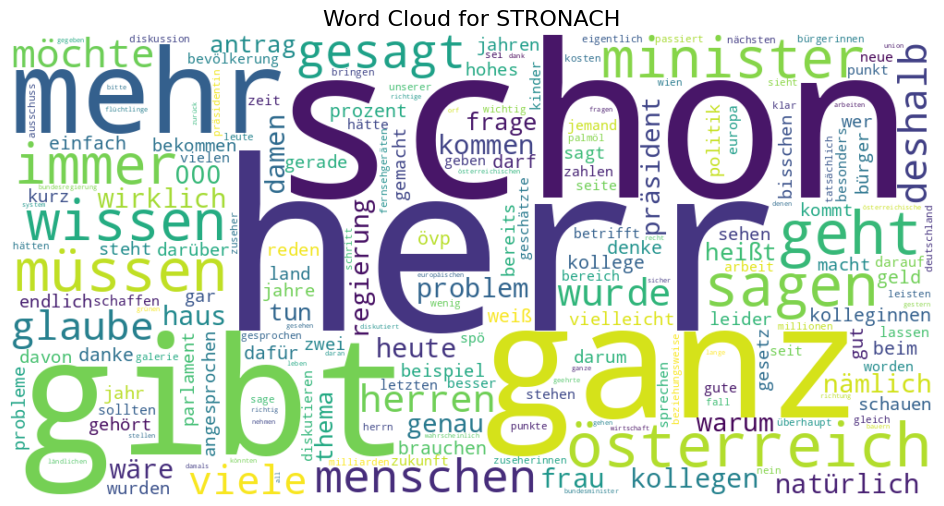

In [31]:
top_3_parties = final_df['Speaker_party'].value_counts().head(10).index
for party in top_3_parties:
    plot_wordcloud(party)

### Task A:

In [32]:
## Loading and splitting data into Datasets
raw_dataset = Dataset.from_pandas(final_df)
raw_dataset = raw_dataset.shuffle(seed=42)

split1 = raw_dataset.train_test_split(test_size=0.3, seed=42)
split2 = split1["test"].train_test_split(test_size=0.5, seed=42)

train_ds = split1["train"]
val_ds = split2["train"]     # Used for eval during training/fine-tuning
test_ds = split2["test"]     # Used *only* for final evaluation


print(f"📚 Training samples: {len(train_ds)}")
print(f"📚 Validation samples: {len(val_ds)}")
print(f"🧪 Test samples: {len(test_ds)}")

# Define party labels
partys=final_df["Speaker_party"].unique().tolist()

# Label Map
label_map = {label: idx for idx, label in enumerate(partys)}
label_map["unknown"] = len(label_map)

📚 Training samples: 13337
📚 Validation samples: 2858
🧪 Test samples: 2858


In [33]:

# Initial model configuration
model_name = "Qwen/Qwen3-0.6B"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🔧 Loading Qwen 3 model: {model_name}")
print(f"💻 Device: {device}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load Qwen 3 model (full precision)
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto" if torch.cuda.is_available() else None,
)

print("✅ Qwen 3 model and tokenizer loaded successfully!")
print(f"📊 Model parameters: {base_model.num_parameters():,}")
print(f"🔥 Model size: Only 0.6B parameters - perfect for education!")


🔧 Loading Qwen 3 model: Qwen/Qwen3-0.6B
💻 Device: cuda
✅ Qwen 3 model and tokenizer loaded successfully!
📊 Model parameters: 596,049,920
🔥 Model size: Only 0.6B parameters - perfect for education!


In [34]:
# Prediction and Evaluation functions

def generate_prediction(text, model, tokenizer, labels, use_instruction_prompt=True, label_type="Party"):
    """
    Generate label prediction using multi-token logit scoring.
    Works for both parties and orientations.
    """
    label_tokens = {label: tokenizer.encode(" " + label, add_special_tokens=False) for label in labels}

    if use_instruction_prompt:
        prompt = (
            "You are an expert on Austrian politics and parliamentary discourse.\n"
            f"Read the following speech excerpt from a session in the Austrian National Council (Nationalrat).\n"
            f"Based on the speaker's language, tone, and content, identify which political {label_type.lower()} they most likely represent from this list: {labels}.\n\n"
            f"Only return the {label_type.lower()} abbreviation, nothing else.\n\n"
            f"Speech:\n{text.strip()}\n\n{label_type}:"
        )
    else:
        prompt = f"{text.strip()}\n\n{label_type}:"

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(model.device)

    with torch.inference_mode():
        outputs = model(**inputs)
        logits = outputs.logits

    start = inputs["input_ids"].shape[1] - 1
    scores = {}
    for label, token_ids in label_tokens.items():
        score = 0.0
        for i, token_id in enumerate(token_ids):
            if start + i >= logits.shape[1]:
                break
            score += logits[0, start + i, token_id].item()
        scores[label] = score

    return max(scores, key=scores.get)


def evaluate_model_predictions(model, model_name, eval_dataset, tokenizer, label_map, partys, num_samples=None, verbose=True, use_instruction_prompt=True):
    """
    Evaluate the model on a dataset using logit-based party classification.
    """
    model.eval()
    predictions = []
    true_labels = []

    if num_samples is None:
        num_samples = len(eval_dataset)

    print(f"\n🔍 Evaluating {model_name} on {num_samples} samples...")

    for i in range(min(num_samples, len(eval_dataset))):
        sample = eval_dataset[i]

        # Run prediction
        prediction_raw = generate_prediction(sample['text'], model, tokenizer, partys, use_instruction_prompt=use_instruction_prompt, label_type="Party").strip()

        # Normalize prediction
        normalized_pred = prediction_raw.lower().strip()

        # Check if normalized prediction matches any label exactly (case-insensitive)
        label_lookup = {label.lower(): label for label in label_map.keys()}
        prediction = label_lookup.get(normalized_pred, "unknown")

        predictions.append(prediction)
        true_labels.append(sample["Speaker_party"])

        # Log progress
        if verbose:
            if (i + 1) % 10 == 0:
                print(f"   Processed {i + 1}/{num_samples} samples...")

            if i < 3:
                print(f"\n   Example {i+1}:")
                print(f"      True: {sample['Speaker_party']}")
                print(f"      Raw Prediction: {prediction_raw}")
                print(f"      Matched Label: {prediction}")

    return predictions, true_labels



In [35]:
# Preparing instruction prompts for fine-tuning

def prepare_instruction_dataset(dataset, tokenizer, partys, max_length=512):
    """
    Prepare dataset for instruction fine-tuning of a *base* Qwen 3 model.
    No chat formatting — just plain instruction + label completion.
    """
    # Convert to pandas DataFrame
    if hasattr(dataset, 'to_pandas'):
        df = dataset.to_pandas()
    else:
        df = pd.DataFrame(dataset)

    formatted_texts = []

    print(f"🔄 Preparing {len(df)} speech examples for instruction fine-tuning...")

    for _, row in df.iterrows():
        # Plain instruction prompt + label target
        prompt = (
            "You are an expert on Austrian politics and parliamentary discourse.\n"
            "Read the following speech excerpt from a session in the Austrian National Council (Nationalrat).\n"
            f"Based on the speaker's language, tone, and content, identify which political party they most likely represent from this list: {partys}.\n\n"
            "Only return the party abbreviation, nothing else.\n\n"
            f"Speech:\n{row['text'].strip()}\n\nParty:"
        )
        target = f" {row['Speaker_party'].strip()}{tokenizer.eos_token}"  # Include EOS token
        full_example = prompt + target

        formatted_texts.append(full_example)

    print(f"📜 Example formatted instruction:\n\n{formatted_texts[0]}")

    # Tokenize all examples
    print(f"🔄 Tokenizing {len(formatted_texts)} samples...")

    tokenized = tokenizer(
        formatted_texts,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt",
        return_attention_mask=True,
    )

    # Causal LM: mask pad tokens in labels
    input_ids = tokenized["input_ids"]
    attention_mask = tokenized["attention_mask"]
    labels = input_ids.clone()
    labels[input_ids == tokenizer.pad_token_id] = -100

    # Return as HuggingFace Dataset
    return Dataset.from_dict({
        "input_ids": input_ids.tolist(),
        "attention_mask": attention_mask.tolist(),
        "labels": labels.tolist(),
    })

# Prepare instruction datasets
print("🔄 Preparing instruction fine-tuning datasets...")
print("💡 Using shorter sequences (512 tokens) and proper padding for stable training...")
print("🔚 IMPORTANT: Adding EOS tokens to teach the model when to stop generating!")
inst_train_ds = prepare_instruction_dataset(train_ds, tokenizer, partys)
inst_eval_ds = prepare_instruction_dataset(val_ds, tokenizer, partys)

print("✅ Instruction datasets ")
print(f"📊 Training samples: {len(inst_train_ds)}")
print(f"📊 Validation samples: {len(inst_eval_ds)}")


🔄 Preparing instruction fine-tuning datasets...
💡 Using shorter sequences (512 tokens) and proper padding for stable training...
🔚 IMPORTANT: Adding EOS tokens to teach the model when to stop generating!
🔄 Preparing 13337 speech examples for instruction fine-tuning...
📜 Example formatted instruction:

You are an expert on Austrian politics and parliamentary discourse.
Read the following speech excerpt from a session in the Austrian National Council (Nationalrat).
Based on the speaker's language, tone, and content, identify which political party they most likely represent from this list: ['SPÖ', 'ÖVP', 'FPÖ', 'Grüne', 'NEOS', 'JETZT', 'STRONACH'].

Only return the party abbreviation, nothing else.

Speech:
Sehr geehrte Frau Präsidentin! Sehr geehrter Herr Minister! Werte Kolleginnen und Kollegen! Wir haben ja bereits im Jahr 2009 beschlossen, dass wir die Neuadaptierung der Ausstellung in Auschwitz finanzieren werden. Wir haben Geld dafür in die Hand genommen, dass die Lagerbaracke für 

In [ ]:

# Setup LoRA for efficient fine-tuning

# ⚙️ LoRA Configuration
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,         # Causal LM for next-token prediction
    inference_mode=False,                 # Training mode
    r=8,                                  # Lower rank to reduce adapter memory
    lora_alpha=16,                         # Match scaling to 2 * r
    lora_dropout=0.1,                     # Regular dropout
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)

# Create LoRA model for instruction tuning
print("🔧 Creating LoRA model...")
inst_model = get_peft_model(base_model, lora_config)
inst_model.enable_input_require_grads()
inst_model.print_trainable_parameters()

inst_training_args = TrainingArguments(
    output_dir="./instruction_results",         # Output dir for checkpoints

    num_train_epochs=2,                         # Two epochs should be enough
    per_device_train_batch_size=2,              # Small batch to fit in memory
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,              
    learning_rate=5e-5,                         # Safe starting LR
    warmup_steps=20,                            # Small warmup period

    bf16=True,                                  # Use float16 precision for speed/memory

    # Evaluation & saving
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,                         # Keep only the 2 most recent checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,                    # We're minimizing eval loss

    # Logging
    logging_steps=50,
    report_to=[],                               # No external logging

    # Memory & speed optimizations
    gradient_checkpointing=True,                # Save memory by recomputing activations
    remove_unused_columns=True,                 # Drop unnecessary columns from dataset
    dataloader_pin_memory=False,                # Disable pinned memory (helps in low VRAM)
    dataloader_drop_last=True,                  # Drop incomplete final batch
    max_grad_norm=1.0,                          # Gradient clipping
    no_cuda=False,                              # Ensure GPU is used if available
)


# Data collator for language modeling with proper padding
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # We're doing causal LM, not masked LM
    pad_to_multiple_of=8,
    return_tensors="pt",
)

print("✅ LoRA configuration and training setup completed")

🔧 Creating LoRA model...
trainable params: 5,046,272 || all params: 601,096,192 || trainable%: 0.8395
✅ LoRA configuration and training setup completed


In [ ]:
# Commented out to prevent re-training

# # Create trainer for instruction tuning
# inst_trainer = Trainer(
#     model=inst_model,
#     args=inst_training_args,
#     train_dataset=inst_train_ds,
#     eval_dataset=inst_eval_ds,
#     data_collator=data_collator,
# )

# print("🎯 Starting Instruction fine-tuning of Qwen 3...")
# print("⏱️  This may take a while depending on your hardware...")


# #-------------------------------------------------------------------------------------

# # Train the model
# training_output = inst_trainer.train()

# print("✅ Instruction fine-tuning completed!")
# print(f"📊 Final training loss: {training_output.training_loss:.4f}")

# # Save the fine-tuned model
# print("💾 Saving fine-tuned model...")
# inst_trainer.save_model("./qwen3_ParliaMint_party_finetuned")
# tokenizer.save_pretrained("./qwen3_ParliaMint_party_finetuned")

In [21]:
# # Free training memory
# del inst_trainer
# del inst_train_ds, inst_eval_ds
# del training_output
torch.cuda.empty_cache()
import gc
gc.collect()
print("🧹 Training memory freed. Only base and fine-tuned models remain.")

🧹 Training memory freed. Only base and fine-tuned models remain.


📏 Evaluating Base Qwen 3 Model...

🔍 Evaluating Fine-Tuned Qwen 3 on 2858 samples...

   Example 1:
      True: FPÖ
      Raw Prediction: Grüne
      Matched Label: Grüne

   Example 2:
      True: FPÖ
      Raw Prediction: SPÖ
      Matched Label: SPÖ

   Example 3:
      True: Grüne
      Raw Prediction: FPÖ
      Matched Label: FPÖ
   Processed 10/2858 samples...
   Processed 20/2858 samples...
   Processed 30/2858 samples...
   Processed 40/2858 samples...
   Processed 50/2858 samples...
   Processed 60/2858 samples...
   Processed 70/2858 samples...
   Processed 80/2858 samples...
   Processed 90/2858 samples...
   Processed 100/2858 samples...
   Processed 110/2858 samples...
   Processed 120/2858 samples...
   Processed 130/2858 samples...
   Processed 140/2858 samples...
   Processed 150/2858 samples...
   Processed 160/2858 samples...
   Processed 170/2858 samples...
   Processed 180/2858 samples...
   Processed 190/2858 samples...
   Processed 200/2858 samples...
   Processed

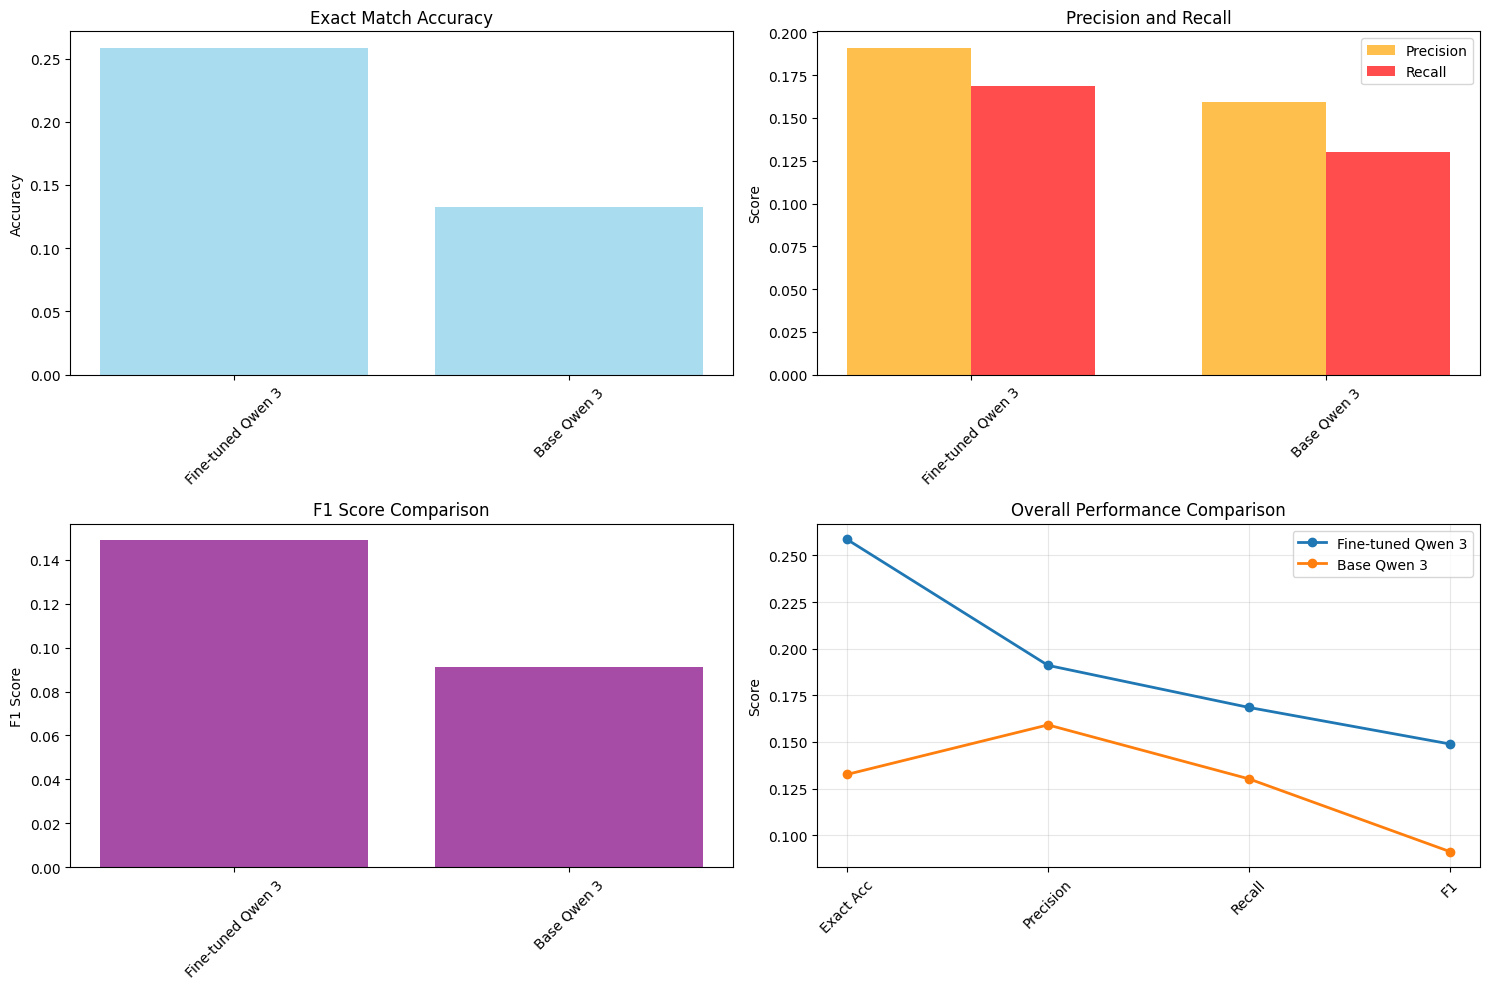

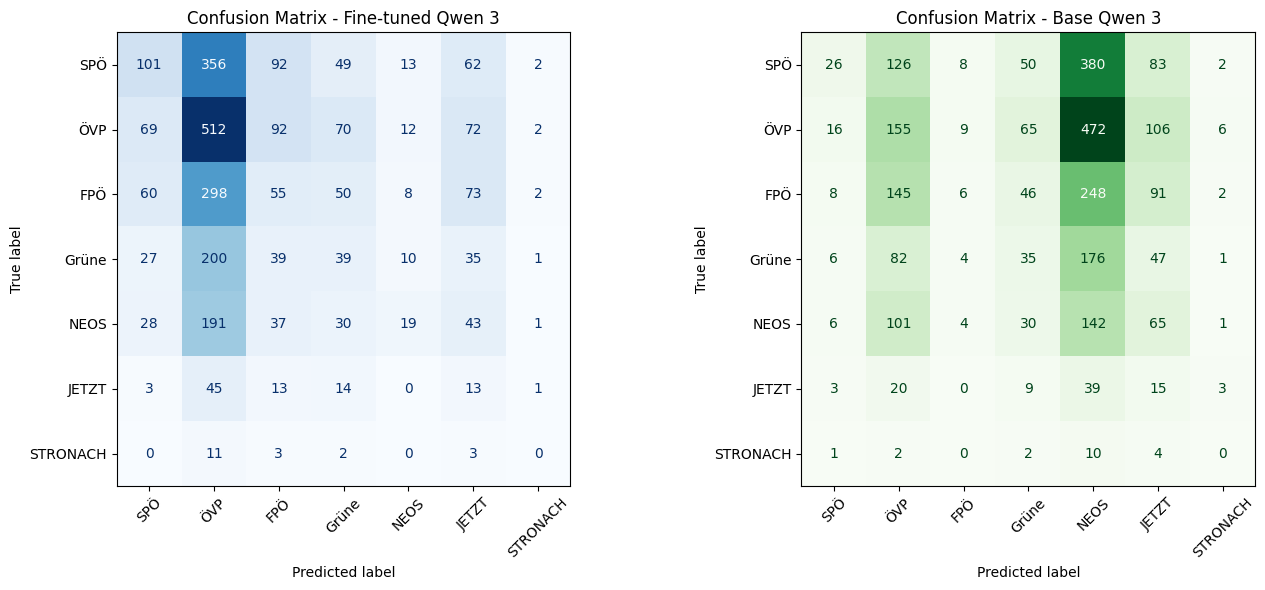

In [18]:

# Collect true labels
true_labels = [ex["Speaker_party"] for ex in test_ds]

base_model= AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

# Load separate base model for finetuning (important!)
base_model_for_ft = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

# Load fine-tuned LoRA on top
finetuned_model = PeftModel.from_pretrained(
    model=base_model_for_ft,
    model_id="./qwen3_ParliaMint_party_finetuned"
)


# Evaluate models
results = {}

print("📏 Evaluating Base Qwen 3 Model...")
finetuned_preds, finetuned_true = evaluate_model_predictions(
    model=finetuned_model,
    model_name="Fine-Tuned Qwen 3",
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    partys=partys,
    label_map=label_map
)
results["Fine-tuned Qwen 3"] = finetuned_preds

print("📏 Evaluating Fine-tuned Qwen 3 Model...")
base_preds, base_true = evaluate_model_predictions(
    model=base_model,
    model_name="Base Qwen 3",
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    partys=partys,
    label_map=label_map
)
results["Base Qwen 3"] = base_preds



# Metric calculation
def calculate_exact_match_accuracy(predictions, true_labels):
    matches = sum(1 for pred, true in zip(predictions, true_labels) if pred.strip().lower() == true.strip().lower())
    return matches / len(predictions)

metrics_summary = {}

for model_name, preds in results.items():
    # Encode predictions and true labels
    y_true = [label_map[t] for t in true_labels]
    y_pred = [label_map.get(p.strip(), -1) for p in preds]

    # Filter out unknown predictions
    valid_indices = [i for i, p in enumerate(y_pred) if p != -1]
    y_true_filtered = [y_true[i] for i in valid_indices]
    y_pred_filtered = [y_pred[i] for i in valid_indices]

    exact_acc = calculate_exact_match_accuracy(preds, true_labels)
    precision = precision_score(y_true_filtered, y_pred_filtered, average="macro", zero_division=0)
    recall = recall_score(y_true_filtered, y_pred_filtered, average="macro", zero_division=0)
    f1 = f1_score(y_true_filtered, y_pred_filtered, average="macro", zero_division=0)

    metrics_summary[model_name] = {
        'exact_acc': exact_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_true': y_true_filtered,
        'y_pred': y_pred_filtered,
    }

    print(f"\n🤖 {model_name}:")
    print(f"   📊 Exact Match Accuracy: {exact_acc:.3f}")
    print(f"   📊 Average Precision: {precision:.3f}")
    print(f"   📊 Average Recall: {recall:.3f}")
    print(f"   📊 F1 Score: {f1:.3f}")


# Comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

model_names = list(metrics_summary.keys())
exact_accuracies = [metrics_summary[name]['exact_acc'] for name in model_names]
precisions = [metrics_summary[name]['precision'] for name in model_names]
recalls = [metrics_summary[name]['recall'] for name in model_names]
f1_scores = [metrics_summary[name]['f1'] for name in model_names]

# Accuracy
axes[0, 0].bar(model_names, exact_accuracies, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Exact Match Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)

# Precision and Recall
x = np.arange(len(model_names))
width = 0.35
axes[0, 1].bar(x - width/2, precisions, width, label='Precision', alpha=0.7, color='orange')
axes[0, 1].bar(x + width/2, recalls, width, label='Recall', alpha=0.7, color='red')
axes[0, 1].set_title('Precision and Recall')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(model_names, rotation=45)
axes[0, 1].legend()

# F1 Score
axes[1, 0].bar(model_names, f1_scores, alpha=0.7, color='purple')
axes[1, 0].set_title('F1 Score Comparison')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].tick_params(axis='x', rotation=45)

# Performance line plot
metrics = ['Exact Acc', 'Precision', 'Recall', 'F1']
for name in model_names:
    values = [
        metrics_summary[name]['exact_acc'],
        metrics_summary[name]['precision'],
        metrics_summary[name]['recall'],
        metrics_summary[name]['f1'],
    ]
    axes[1, 1].plot(metrics, values, marker='o', label=name, linewidth=2)

axes[1, 1].set_title('Overall Performance Comparison')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Confusion matrices

fig_cm, axes_cm = plt.subplots(1, 2, figsize=(14, 6))

# Exclude "unknown" from label_map
filtered_labels = [label for label in label_map if label != "unknown"]
filtered_label_ids = [label_map[label] for label in filtered_labels]

for i, model_name in enumerate(model_names):
    y_true_all = metrics_summary[model_name]['y_true']
    y_pred_all = metrics_summary[model_name]['y_pred']

    # Filter out unknowns (by ID)
    unknown_id = label_map["unknown"]
    valid_indices = [
        idx for idx, (yt, yp) in enumerate(zip(y_true_all, y_pred_all))
        if yt != unknown_id and yp != unknown_id
    ]
    y_true_filtered = [y_true_all[idx] for idx in valid_indices]
    y_pred_filtered = [y_pred_all[idx] for idx in valid_indices]

    # Compute confusion matrix without unknown
    cm = confusion_matrix(
        y_true_filtered,
        y_pred_filtered,
        labels=filtered_label_ids
    )
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=filtered_labels)
    disp.plot(ax=axes_cm[i], xticks_rotation=45, cmap='Blues' if i == 0 else 'Greens', colorbar=False)
    axes_cm[i].set_title(f"Confusion Matrix - {model_name}")

plt.tight_layout()
plt.show()

### Task B:

In [36]:

# Loading/splitting into Datasets
raw_dataset = Dataset.from_pandas(final_df)
raw_dataset = raw_dataset.shuffle(seed=42)

split1 = raw_dataset.train_test_split(test_size=0.3, seed=42)
split2 = split1["test"].train_test_split(test_size=0.5, seed=42)

train_ds = split1["train"]
val_ds = split2["train"]     
test_ds = split2["test"]     



print(f"📚 Training samples: {len(train_ds)}")
print(f"📚 Validation samples: {len(val_ds)}")
print(f"🧪 Test samples: {len(test_ds)}")


# Define your orientation labels
orientations = ["Left", "Centre", "Right"]
# Build label map for classification report or metrics
label_map = {label: idx for idx, label in enumerate(orientations)}
label_map["unknown"] = len(label_map)

📚 Training samples: 13337
📚 Validation samples: 2858
🧪 Test samples: 2858


In [37]:

# Another Model configuration
model_name = "Qwen/Qwen3-0.6B"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🔧 Loading Qwen 3 model: {model_name}")
print(f"💻 Device: {device}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load Qwen 3 model (full precision)
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto" if torch.cuda.is_available() else None,
)

print("✅ Qwen 3 model and tokenizer loaded successfully!")
print(f"📊 Model parameters: {base_model.num_parameters():,}")
print(f"🔥 Model size: Only 0.6B parameters - perfect for education!")


🔧 Loading Qwen 3 model: Qwen/Qwen3-0.6B
💻 Device: cuda
✅ Qwen 3 model and tokenizer loaded successfully!
📊 Model parameters: 596,049,920
🔥 Model size: Only 0.6B parameters - perfect for education!


In [38]:
# Similar as above

def generate_prediction(text, model, tokenizer, labels, use_instruction_prompt=True, label_type="Orientation"):
    """
    Generate label prediction using multi-token logit scoring.
    Adapted for political orientation classification.
    """
    label_tokens = {label: tokenizer.encode(" " + label, add_special_tokens=False) for label in labels}

    if use_instruction_prompt:
        prompt = (
            "You are an expert on Austrian politics and parliamentary discourse.\n"
            f"Read the following speech excerpt from a session in the Austrian National Council (Nationalrat).\n"
            f"Based on the speaker's language, tone, and content, identify which political {label_type.lower()} they most likely represent from this list: {labels}.\n\n"
            f"Only return the {label_type.lower()} label, nothing else.\n\n"
            f"Speech:\n{text.strip()}\n\n{label_type}:"
        )
    else:
        prompt = f"{text.strip()}\n\n{label_type}:"

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(model.device)

    with torch.inference_mode():
        outputs = model(**inputs)
        logits = outputs.logits

    start = inputs["input_ids"].shape[1] - 1
    scores = {}
    for label, token_ids in label_tokens.items():
        score = 0.0
        for i, token_id in enumerate(token_ids):
            if start + i >= logits.shape[1]:
                break
            score += logits[0, start + i, token_id].item()
        scores[label] = score

    return max(scores, key=scores.get)


def evaluate_model_predictions(model, model_name, eval_dataset, tokenizer, label_map, orientations, num_samples=None, verbose=True, use_instruction_prompt=True):
    """
    Evaluate the model on a dataset using logit-based orientation classification.
    """
    model.eval()
    predictions = []
    true_labels = []

    if num_samples is None:
        num_samples = len(eval_dataset)

    print(f"\n🔍 Evaluating {model_name} on {num_samples} samples...")

    for i in range(min(num_samples, len(eval_dataset))):
        sample = eval_dataset[i]

        prediction_raw = generate_prediction(
            text=sample['text'],
            model=model,
            tokenizer=tokenizer,
            labels=orientations,
            use_instruction_prompt=use_instruction_prompt,
            label_type="Orientation"
        ).strip()

        normalized_pred = prediction_raw.lower().strip()
        label_lookup = {label.lower(): label for label in label_map.keys()}
        prediction = label_lookup.get(normalized_pred, "unknown")

        predictions.append(prediction)
        true_labels.append(sample["Simple_orientation"])

        if verbose:
            if (i + 1) % 10 == 0:
                print(f"   Processed {i + 1}/{num_samples} samples...")

            if i < 3:
                print(f"\n   Example {i+1}:")
                print(f"      True: {sample['Simple_orientation']}")
                print(f"      Raw Prediction: {prediction_raw}")
                print(f"      Matched Label: {prediction}")

    return predictions, true_labels

In [39]:
# Also similar as above
def prepare_instruction_dataset(dataset, tokenizer, orientations, max_length=512):
    """
    Prepare dataset for instruction fine-tuning of a base Qwen 3 model
    for political orientation classification.
    """
    # Convert to pandas DataFrame
    if hasattr(dataset, 'to_pandas'):
        df = dataset.to_pandas()
    else:
        df = pd.DataFrame(dataset)

    formatted_texts = []

    print(f"🔄 Preparing {len(df)} speech examples for instruction fine-tuning (orientation)...")

    for _, row in df.iterrows():
        # Plain instruction-style prompt
        prompt = (
            "You are an expert on Austrian politics and parliamentary discourse.\n"
            "Read the following speech excerpt from a session in the Austrian National Council (Nationalrat).\n"
            f"Based on the speaker's language, tone, and content, identify the political orientation of the speaker from this list: {orientations}.\n\n"
            "Only return the orientation label and nothing else.\n\n"
            f"Speech:\n{row['text'].strip()}\n\nOrientation:"
        )
        
        target = f" {row['Simple_orientation'].strip()}{tokenizer.eos_token}"
        full_text = prompt + target

        formatted_texts.append(full_text)

    print(f"📜 Example formatted prompt:\n\n{formatted_texts[0]}")

    # Tokenize all examples
    print(f"🔄 Tokenizing {len(formatted_texts)} samples...")

    tokenized = tokenizer(
        formatted_texts,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt",
        return_attention_mask=True,
    )

    # Mask padding tokens in labels
    input_ids = tokenized["input_ids"]
    attention_mask = tokenized["attention_mask"]
    labels = input_ids.clone()
    labels[input_ids == tokenizer.pad_token_id] = -100

    return Dataset.from_dict({
        "input_ids": input_ids.tolist(),
        "attention_mask": attention_mask.tolist(),
        "labels": labels.tolist(),
    })

# Prepare instruction datasets
print("🔄 Preparing instruction fine-tuning datasets...")
print("💡 Using shorter sequences (512 tokens) and proper padding for stable training...")
print("🔚 IMPORTANT: Adding EOS tokens to teach the model when to stop generating!")
inst_train_ds = prepare_instruction_dataset(train_ds, tokenizer, orientations)
inst_eval_ds = prepare_instruction_dataset(val_ds, tokenizer, orientations)

print("✅ Instruction datasets ")
print(f"📊 Training samples: {len(inst_train_ds)}")
print(f"📊 Validation samples: {len(inst_eval_ds)}")


🔄 Preparing instruction fine-tuning datasets...
💡 Using shorter sequences (512 tokens) and proper padding for stable training...
🔚 IMPORTANT: Adding EOS tokens to teach the model when to stop generating!
🔄 Preparing 13337 speech examples for instruction fine-tuning (orientation)...
📜 Example formatted prompt:

You are an expert on Austrian politics and parliamentary discourse.
Read the following speech excerpt from a session in the Austrian National Council (Nationalrat).
Based on the speaker's language, tone, and content, identify the political orientation of the speaker from this list: ['Left', 'Centre', 'Right'].

Only return the orientation label and nothing else.

Speech:
Sehr geehrte Frau Präsidentin! Sehr geehrter Herr Minister! Werte Kolleginnen und Kollegen! Wir haben ja bereits im Jahr 2009 beschlossen, dass wir die Neuadaptierung der Ausstellung in Auschwitz finanzieren werden. Wir haben Geld dafür in die Hand genommen, dass die Lagerbaracke für diese museale Darstellung ada

In [40]:

# Setup LoRA for efficient fine-tuning

# ⚙️ LoRA Configuration
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,         # Causal LM for next-token prediction
    inference_mode=False,                 # Training mode
    r=8,                                  # Lower rank to reduce adapter memory
    lora_alpha=16,                         # Match scaling to 2 * r
    lora_dropout=0.1,                     # Regular dropout
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)

# Create LoRA model for instruction tuning
print("🔧 Creating LoRA model...")
inst_model = get_peft_model(base_model, lora_config)
inst_model.enable_input_require_grads()
inst_model.print_trainable_parameters()

inst_training_args = TrainingArguments(
    output_dir="./instruction_results",         # Output dir for checkpoints

    num_train_epochs=2,                         # Two epochs should be enough
    per_device_train_batch_size=2,              # Small batch to fit in memory
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,             

    learning_rate=5e-5,                         # Safe starting LR
    warmup_steps=20,                            # Small warmup period

    bf16=True,                                  # Use float16 precision for speed/memory

    # Evaluation & saving
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,                         # Keep only the 2 most recent checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,                    # We're minimizing eval loss

    # Logging
    logging_steps=50,
    report_to=[],                               # No external logging

    # Memory & speed optimizations
    gradient_checkpointing=True,                # Save memory by recomputing activations
    remove_unused_columns=True,                 # Drop unnecessary columns from dataset
    dataloader_pin_memory=False,                # Disable pinned memory (helps in low VRAM)
    dataloader_drop_last=True,                  # Drop incomplete final batch
    max_grad_norm=1.0,                          # Gradient clipping
    no_cuda=False,                              # Ensure GPU is used if available
)


# Data collator for language modeling with proper padding
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # We're doing causal LM, not masked LM
    pad_to_multiple_of=8,
    return_tensors="pt",
)

print("✅ LoRA configuration and training setup completed")

🔧 Creating LoRA model...
trainable params: 5,046,272 || all params: 601,096,192 || trainable%: 0.8395
✅ LoRA configuration and training setup completed


In [ ]:
# Again, commented out to prevent re-training

# # Create trainer for instruction tuning
# inst_trainer = Trainer(
#     model=inst_model,
#     args=inst_training_args,
#     train_dataset=inst_train_ds,
#     eval_dataset=inst_eval_ds,
#     data_collator=data_collator,
# )

# print("🎯 Starting Instruction fine-tuning of Qwen 3...")
# print("⏱️  This may take a while depending on your hardware...")

# # Train the model
# training_output = inst_trainer.train()

# print("✅ Instruction fine-tuning completed!")
# print(f"📊 Final training loss: {training_output.training_loss:.4f}")

# # Save the fine-tuned model
# print("💾 Saving fine-tuned model...")
# inst_trainer.save_model("./qwen3_ParliaMint_orientations_finetuned")
# tokenizer.save_pretrained("./qwen3_ParliaMint_orientations_finetuned")

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


🎯 Starting Instruction fine-tuning of Qwen 3...
⏱️  This may take a while depending on your hardware...


Here, my laptop randomly restarted but fortunately, finetuning finished in the Jupyter Hub.

In [ ]:
# Free training memory
# del inst_trainer
# del inst_train_ds, inst_eval_ds
# del training_output

torch.cuda.empty_cache()
import gc
gc.collect()

print("🧹 Training memory freed. Only base and fine-tuned models remain.")

🧹 Training memory freed. Only base and fine-tuned models remain.


📏 Evaluating Fine-tuned Qwen 3 Model...

🔍 Evaluating Fine-tuned Qwen 3 on 2858 samples...

   Example 1:
      True: Right
      Raw Prediction: Left
      Matched Label: Left

   Example 2:
      True: Right
      Raw Prediction: Right
      Matched Label: Right

   Example 3:
      True: Left
      Raw Prediction: Left
      Matched Label: Left
   Processed 10/2858 samples...
   Processed 20/2858 samples...
   Processed 30/2858 samples...
   Processed 40/2858 samples...
   Processed 50/2858 samples...
   Processed 60/2858 samples...
   Processed 70/2858 samples...
   Processed 80/2858 samples...
   Processed 90/2858 samples...
   Processed 100/2858 samples...
   Processed 110/2858 samples...
   Processed 120/2858 samples...
   Processed 130/2858 samples...
   Processed 140/2858 samples...
   Processed 150/2858 samples...
   Processed 160/2858 samples...
   Processed 170/2858 samples...
   Processed 180/2858 samples...
   Processed 190/2858 samples...
   Processed 200/2858 samples...

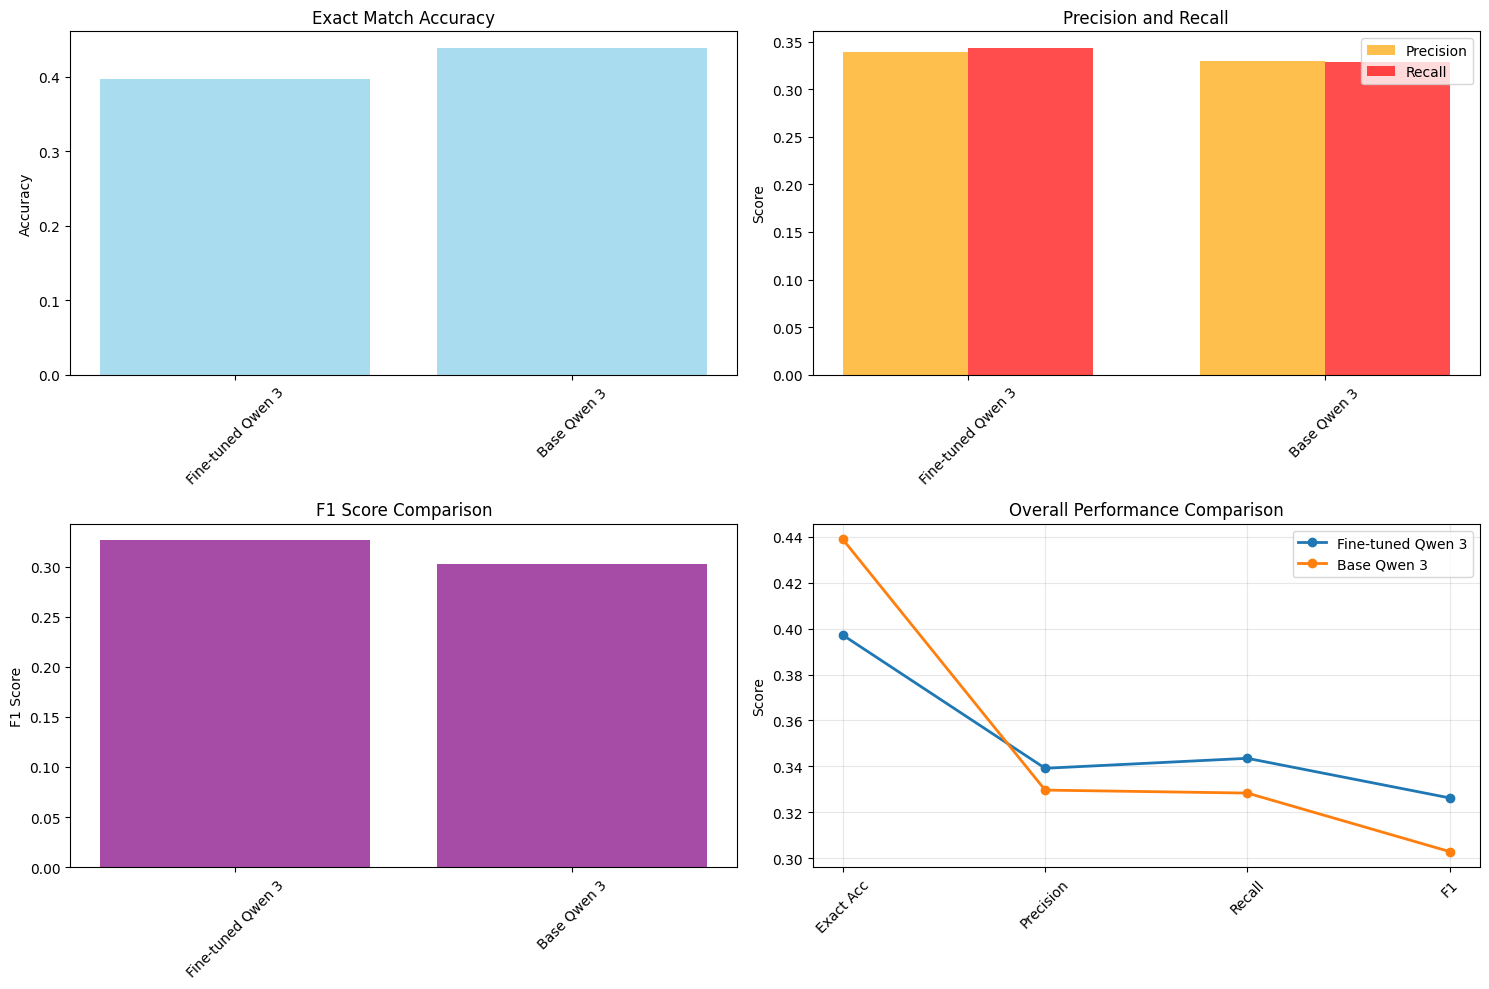

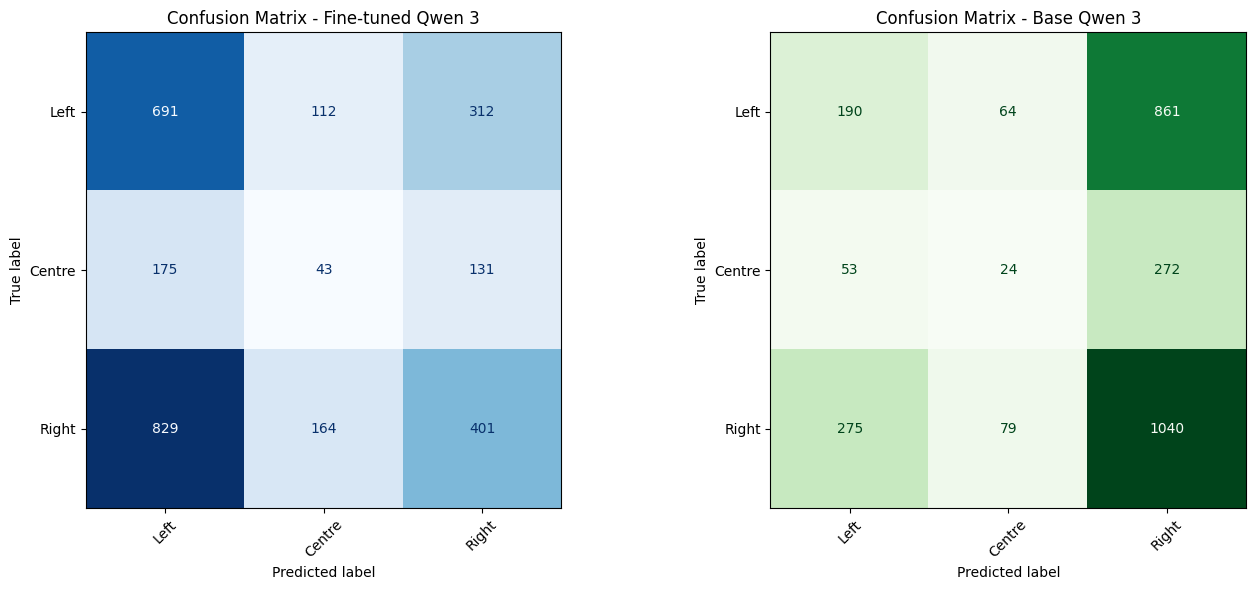

In [ ]:
# Re-load base and fine-tuned models:

# Define true labels for Task B (orientation)
true_labels = [ex["Simple_orientation"] for ex in test_ds]

# Load base model (Qwen 3 - no fine-tuning)
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

# Separate base model for loading the fine-tuned LoRA adapter
base_model_for_ft = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

# Load LoRA adapter (fine-tuned for orientation classification)
finetuned_model = PeftModel.from_pretrained(
    base_model_for_ft,
    "./qwen3_ParliaMint_orientations_finetuned"
)

# Ensure model is in evaluation mode
finetuned_model.eval()
base_model.eval()

# Store results
results = {}

# 🔍 Evaluate fine-tuned model (with instruction-style prompts)
print("📏 Evaluating Fine-tuned Qwen 3 Model...")
finetuned_preds, _ = evaluate_model_predictions(
    model=finetuned_model,
    model_name="Fine-tuned Qwen 3",
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    label_map=label_map,
    orientations=orientations,
    use_instruction_prompt=True  # fine-tuned model expects instruction
)
results["Fine-tuned Qwen 3"] = finetuned_preds

# 🔍 Evaluate base model (no instruction prompt)
print("📏 Evaluating Base Qwen 3 Model...")
base_preds, _ = evaluate_model_predictions(
    model=base_model,
    model_name="Base Qwen 3",
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    label_map=label_map,
    orientations=orientations,
    use_instruction_prompt=False  # base model gets minimal prompt
)
results["Base Qwen 3"] = base_preds


# Metric calculation
def calculate_exact_match_accuracy(predictions, true_labels):
    matches = sum(1 for pred, true in zip(predictions, true_labels) if pred.strip().lower() == true.strip().lower())
    return matches / len(predictions)

metrics_summary = {}

for model_name, preds in results.items():
    # Encode predictions and true labels
    y_true = [label_map[t] for t in true_labels]
    y_pred = [label_map.get(p.strip(), -1) for p in preds]

    # Filter out unknown predictions
    valid_indices = [i for i, p in enumerate(y_pred) if p != -1]
    y_true_filtered = [y_true[i] for i in valid_indices]
    y_pred_filtered = [y_pred[i] for i in valid_indices]

    exact_acc = calculate_exact_match_accuracy(preds, true_labels)
    precision = precision_score(y_true_filtered, y_pred_filtered, average="macro", zero_division=0)
    recall = recall_score(y_true_filtered, y_pred_filtered, average="macro", zero_division=0)
    f1 = f1_score(y_true_filtered, y_pred_filtered, average="macro", zero_division=0)

    metrics_summary[model_name] = {
        'exact_acc': exact_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_true': y_true_filtered,
        'y_pred': y_pred_filtered,
    }

    print(f"\n🤖 {model_name}:")
    print(f"   📊 Exact Match Accuracy: {exact_acc:.3f}")
    print(f"   📊 Average Precision: {precision:.3f}")
    print(f"   📊 Average Recall: {recall:.3f}")
    print(f"   📊 F1 Score: {f1:.3f}")

# ========================
# 📈 METRICS COMPARISON PLOTS
# ========================
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

model_names = list(metrics_summary.keys())
exact_accuracies = [metrics_summary[name]['exact_acc'] for name in model_names]
precisions = [metrics_summary[name]['precision'] for name in model_names]
recalls = [metrics_summary[name]['recall'] for name in model_names]
f1_scores = [metrics_summary[name]['f1'] for name in model_names]

# Accuracy
axes[0, 0].bar(model_names, exact_accuracies, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Exact Match Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)

# Precision and Recall
x = np.arange(len(model_names))
width = 0.35
axes[0, 1].bar(x - width/2, precisions, width, label='Precision', alpha=0.7, color='orange')
axes[0, 1].bar(x + width/2, recalls, width, label='Recall', alpha=0.7, color='red')
axes[0, 1].set_title('Precision and Recall')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(model_names, rotation=45)
axes[0, 1].legend()

# F1 Score
axes[1, 0].bar(model_names, f1_scores, alpha=0.7, color='purple')
axes[1, 0].set_title('F1 Score Comparison')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].tick_params(axis='x', rotation=45)

# Performance line plot
metrics = ['Exact Acc', 'Precision', 'Recall', 'F1']
for name in model_names:
    values = [
        metrics_summary[name]['exact_acc'],
        metrics_summary[name]['precision'],
        metrics_summary[name]['recall'],
        metrics_summary[name]['f1'],
    ]
    axes[1, 1].plot(metrics, values, marker='o', label=name, linewidth=2)

axes[1, 1].set_title('Overall Performance Comparison')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========================
# 🔍 CONFUSION MATRIX PLOTS (SEPARATE)
# ========================
fig_cm, axes_cm = plt.subplots(1, 2, figsize=(14, 6))

# Exclude "unknown" from label_map
filtered_labels = [label for label in label_map if label != "unknown"]
filtered_label_ids = [label_map[label] for label in filtered_labels]

for i, model_name in enumerate(model_names):
    y_true_all = metrics_summary[model_name]['y_true']
    y_pred_all = metrics_summary[model_name]['y_pred']

    # Filter out unknowns (by ID)
    unknown_id = label_map["unknown"]
    valid_indices = [
        idx for idx, (yt, yp) in enumerate(zip(y_true_all, y_pred_all))
        if yt != unknown_id and yp != unknown_id
    ]
    y_true_filtered = [y_true_all[idx] for idx in valid_indices]
    y_pred_filtered = [y_pred_all[idx] for idx in valid_indices]

    # Compute confusion matrix without unknown
    cm = confusion_matrix(
        y_true_filtered,
        y_pred_filtered,
        labels=filtered_label_ids
    )
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=filtered_labels)
    disp.plot(ax=axes_cm[i], xticks_rotation=45, cmap='Blues' if i == 0 else 'Greens', colorbar=False)
    axes_cm[i].set_title(f"Confusion Matrix - {model_name}")

plt.tight_layout()
plt.show()